<a href="https://colab.research.google.com/github/laveshnk-crypto/chess-genetic/blob/main/genetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy
!pip install python-chess
!pip install --upgrade scipy

In [ ]:
!wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
    unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt

In [ ]:
!pip install geneticalgorithm

In [12]:
import chess
from chess import engine
# a chess position where white can win in one move
board = chess.Board("5Q2/5K1k/8/8/8/8/8/8 w - - 0 1")

# initialize Stockfish 
engine = engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")

# you can control the engine's search by time or depth
info = engine.analyse(board, chess.engine.Limit(time=0.1))

In [13]:
import chess
from geneticalgorithm import geneticalgorithm as ga

def value_to_piece(value):
    if value == 0:
        return None
    elif value <= 6:
        # Pieces have values 1 through 6
        return chess.Piece(value, chess.WHITE)
    else:
        return chess.Piece(value - 6, chess.BLACK)

def array_to_chess_board(arr):
    # construct an empty chess board
    board = chess.Board(fen='8/8/8/8/8/8/8/8 w - - 0 1')
    for i, value in enumerate(arr):
        piece = value_to_piece(value)
        if piece:
            board.set_piece_at(i, piece)
    return board

In [14]:
def f(X):
    board = array_to_chess_board(X)

    # Let's reward having as few pieces as possible
    penalty = len(board.piece_map()) * 0.1

    # Penalize invalid boards heavily, we cannot even analyze them
    if not board.is_valid():
        return 10 + penalty

    # You can tune the depth for performance reasons
    info = engine.analyse(board, chess.engine.Limit(depth=10), multipv=2)

    # If there are no moves (meaning the game is over), return a high penalty
    if len(info) < 1:
        return 9 + penalty

    # Also heavily penalize having only 1 move, puzzles are only interesting
    #   if we have a choice to make
    if len(info) < 2:
        return 8 + penalty

    # We're specifically looking for puzzles where White can mate in 3 moves
    #   so we'll penalize cases where white does not have a forced mate
    score = info[0]["score"].white()
    if not score.is_mate() or score.mate() <= 0:
        return 6 + penalty

    # Add a penalty for the distance away from mate in 3 
    penalty += min(3, abs(score.mate() - 3)) / 3

    # Finally, add a high penalty if the second best move is also good.
    # The defining characteristic of a puzzle is that the second best move is bad
    second_move_score = info[1]["score"].white().score(mate_score=1000)
    if second_move_score > 100:
        penalty += min(10.0, second_move_score / 100)


    return penalty

 The best solution found:
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  2.  0.  4.  0.  0.  0.  0. 12.
  0.  0.  0.  0.  0.  0.  8.  0.  0. 11.  0.  0.  0.  0.  3.  0.  1.  0.
 11.  0.  0.  0.  8.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  0.  8.  0.  0.  0.  0.  3.  0.  5.  0.]

 Objective function:
 1.5


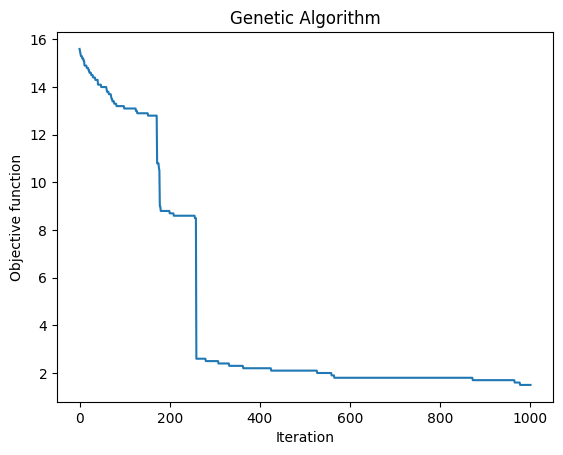

In [20]:
import numpy as np

varbound = np.array([[0, 12]] * 64)
algorithm_param = {'max_num_iteration': 1000,
                   'population_size': 20,
                   'mutation_probability': 0.05,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.9,
                   'parents_portion': 0.3,
                   'crossover_type': 'two_point', 
                   'max_iteration_without_improv': 5000}
model = ga(function=f, dimension=64, variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
model.run()

In [19]:
best_board = array_to_chess_board(list(model.best_variable))
print(best_board.fen())
# 8/8/2K5/8/8/8/8/5k2 w - - 0 1

5q2/8/1q6/8/2R3R1/4B1Q1/3pK1Pb/7k w - - 0 1
